# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [42]:
# Python Standard Library
# -----------------------
pass

In [43]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [44]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [45]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [46]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([ 1.,  2.])

In [47]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[ 1.,  2.],
       [ 3.,  4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [48]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    plt.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.show()

#### Fonction quadratique

In [49]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

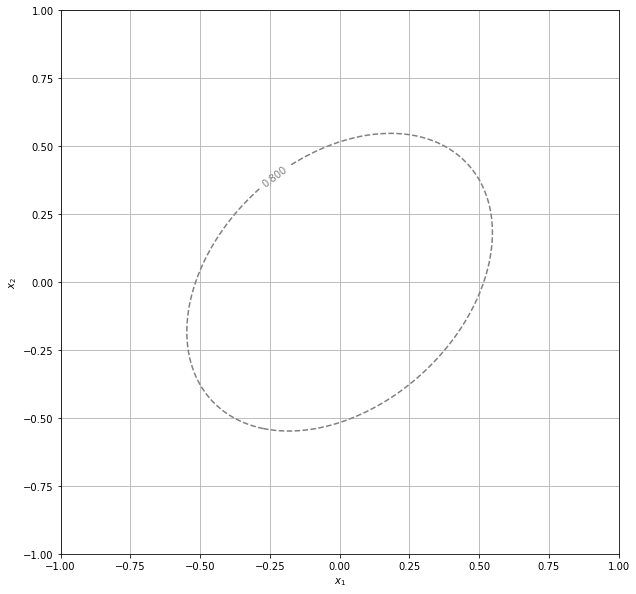

In [50]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=[0.8] # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [51]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

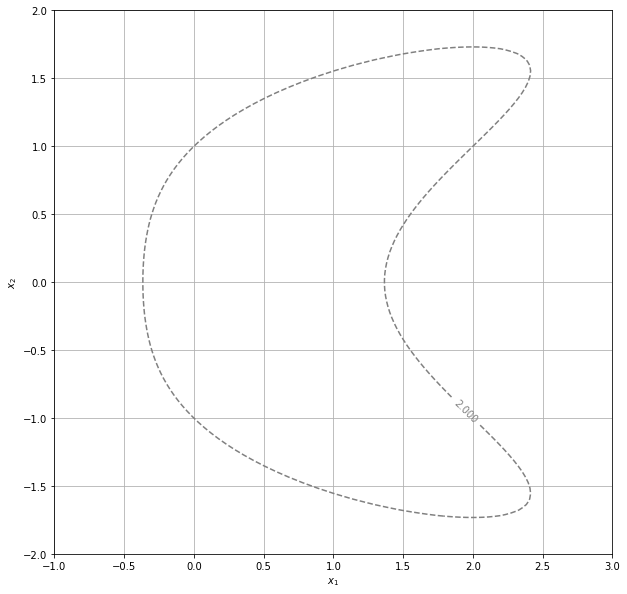

In [52]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2.0]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [53]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

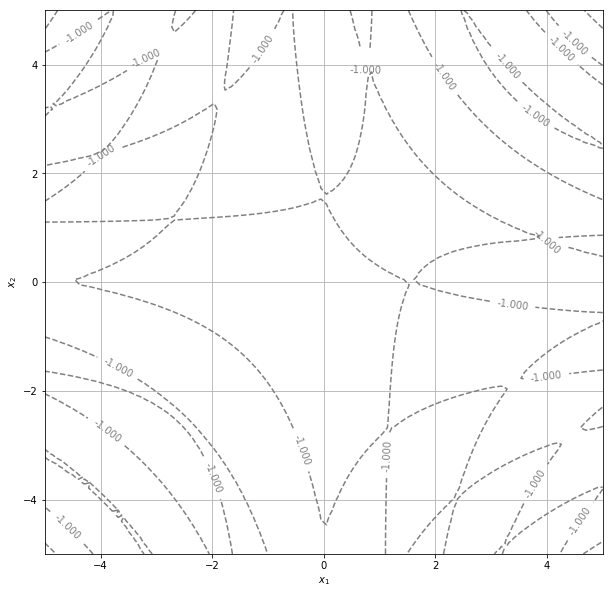

In [54]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=[-1.0], # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

#### Réponse 1
Notons $\  E = \left \{ (x_{1},x_{2}) \in \ \mathbb{R}^{2} /\ f(x_{1},x_{2})\ =\ c \right \} = f^{-1}(\left \{ c \right \})$

Comme $\left \{ c \right \}$ est un fermé, et f est continue, alors $f^{^{-1}}$({c}) = E est un fermé

Traduisons la formule $\left \| (x_1,x_2) \right \| \rightarrow  +\infty  \Rightarrow  \left | f(x_1,x_2) \right |\rightarrow  +\infty $ avec les epsilons. 

$\forall A \geq 0, \exists B \geq 0, \forall (x_1,x_2) \in \mathbb{R}^{2} , \left \| (x_1,x_2) \right \| > B \Rightarrow |f(x_1,x_2)| > A$ 

On va raisonner par contre apposée

Soit x $\in$ E:

Pour A = |c| , $\exists B \geq 0 \forall x \in \mathbb{R}^2 $ on a : |f(x)| = |c| $\geq$ c $\Rightarrow \left \| x \right \| \leq B$

Ce qui revient à dire que l'ensemble E est borné. 

Donc E est un compact de $\mathbb{R}^2$


Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

#### Réponse 2

Ce terme est interprété géometriquement comme l'aire à signe près du parallélogramme formé par les 2 vecteurs $\overrightarrow{u}\ et\ \overrightarrow{v}$ où : 

$\overrightarrow{u} = \binom{x_1-x_{10}}{x_2-x_{20}}\ et\ \overrightarrow{v} = \frac{\nabla(f)}{\left \| \nabla(f) \right \|}$

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

#### Réponse 3

Posons g : $ \mathbb{R}^2*\ \mathbb{R} \rightarrow \mathbb{R}^2$ qui associe à chaque $(x_1,x_2,t)$ le vecteur $\binom{f(x_1,x_2) - c}{p(x_1,x_2)-t}$

On a bien $g(x_0,0) = \binom{0}{0}$

et g est continûment différentiable car ses 2 composantes le sont.

Il faut maintenant que $\partial _xg$ soit inversible au voisinage de $x_0$ pour pouvoir appliquer le théorème des fonctions implicites. Tout calcul fait, det($\partial g_x$)($x_0$) = $\left \| \nabla(f(x_0)) \right \| \neq 0$ d'après les hypothèses

donc $\partial _xg$ est inversible au voisinage de $x_0$

D'après le théorème des fonctions implicites appliqué à g : $\exists$ un voisinage ouvert U de $x_0$, $\exists$ un voisinage ouvert $\left ] -\epsilon, \epsilon   \right [$ de 0 , $\exists$ une unique fonction $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que $\forall (x_1,x_2,t) \in U *\left ] -\epsilon, \epsilon   \right [$, $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

#### Réponse 4

Le théorèùe des fonctions implicite nous fournit de même que : $\forall t \in \left]-\varepsilon,\varepsilon \right[ : d\gamma(t) = \gamma'(t) = -(\partial _xg(x,t))^{-1}.\partial _tg(x,t)$

or $\partial _tg(x,t) = \binom{0}{-1}$ et $\partial _xg(x,t) = \begin{pmatrix}
\partial_1f(x) & \partial_2f(x) \\ 
\frac{\partial_2f(x_0)}{\left \| \nabla f(x_0) \right \|} & -\frac{\partial_1f(x_0)}{\left \| \nabla f(x_0) \right \|}
\end{pmatrix}$

On calcule $(\partial_xg(x,t))^{-1}$: 

$(\partial_xg(x,t))^{-1} = \frac{1}{det(\partial_xg(x,t))}.  \begin{pmatrix}
-\frac{\partial_1f(x_0)}{\left \| \nabla f(x_0) \right \|} & -\partial_2f(x)  \\ 
-\frac{\partial_2f(x_0)}{\left \| \nabla f(x_0) \right \|} & \partial_1f(x)
\end{pmatrix}  $

On conclut par calcul que : $\gamma'(t) = \frac{1}{det(\partial_xg(x)))}.\binom{\partial_2f(\gamma(t))}{-\partial_1f(\gamma(t))}$  $\forall t \in \left]-\varepsilon,\varepsilon \right[$ 
 
Ce vecteur étant non nul au voisinage de $x_0$ car le gradient de f en $x_0$ l'est également.

Graphiquement, on peut bien voir que $\gamma'(t)$ et $\nabla f(\gamma(t))$ sont orthogonaux. Et même analytiquement, leur produit scalaire est nul. 

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [55]:
N = 100
eps = 0.01

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [56]:
def norme(u):   #norme d'un vecteur
    x, y = u[0], u[1]
    return np.sqrt(x**2+y**2)

In [57]:
def Newton(F, x0, y0, eps=0.01, N=100): 
    grad_F = grad(F)
    df1, df2 = grad_F(x0,y0)
    x = x0 - F(x0, y0)*df1/(norme(grad_F(x0,y0))**2)    #initier l'itération
    y = y0 - F(x0, y0)*df2/(norme(grad_F(x0,y0))**2)
    for i in range(N):
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y     #on arrête la boucle
               
        else:
            x0, y0 = x, y    #les étapes d'itération par la méthode de Newton si la précision n'a pas été trouvée
            x = x0 - F(x0, y0)*df1/(norme(grad_F(x0,y0))**2)   
            y = y0 - F(x0, y0)*df2/(norme(grad_F(x0,y0))**2)
        
    else:
        raise ValueError(f"no convergence in {N} steps.")
        

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [58]:
def F1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return f1(x1, x2) - 0.8
Newton(F1, 0.8, 0.8, eps=0.01, N=100)    #on cherche un point (x1,x2) de la ligne de niveau 0.8 de f1 en utilisant le point initial (0.8,0.8)

(0.4441651046849393, 0.4441651046849393)

In [59]:
def display_contour_2(f, x0, y0, x1, y1, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    plt.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.scatter(x0, y0, color="blue")    #point initial en bleu
    plt.scatter(x1, y1, color="red")    #point trouvé par la méthode de Newton en rouge
    plt.show()


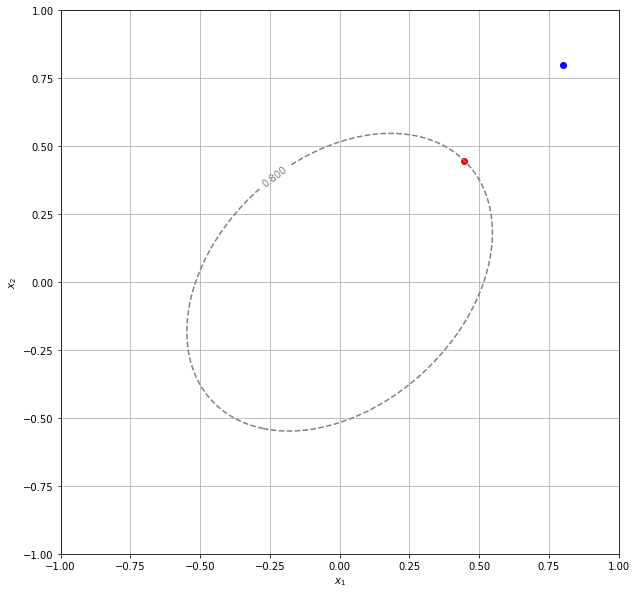

In [60]:
display_contour_2(
    f1,  
    x0=0.8, 
    y0=0.8,
    x1=Newton(F1, 0.8, 0.8, eps=0.01, N=100)[0],
    y1=Newton(F1, 0.8, 0.8, eps=0.01, N=100)[1],
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=[0.8] 
)

In [61]:
def F2(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return f2(x1, x2) - 2.0
Newton(F2, 2.5, 0.5, eps=0.01, N=100)    #on cherche un point (x1,x2) de la ligne de niveau 2.0 de f2 en utilisant le point initial (2.5,0.5)

(1.8730705937542247, 0.87615764374746519)

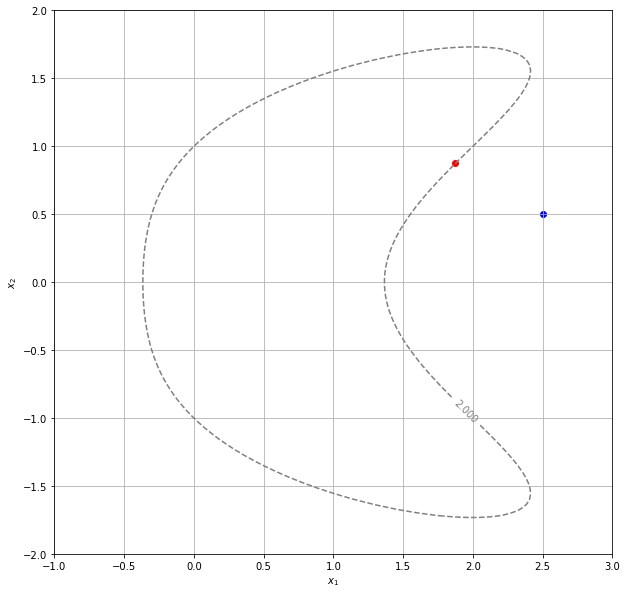

In [62]:
display_contour_2(
    f2,  
    x0=2.5, 
    y0=0.5,
    x1=Newton(F2, 2.5, 0.5, eps=0.01, N=100)[0],
    y1=Newton(F2, 2.5, 0.5, eps=0.01, N=100)[1],
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2.0] 
)

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

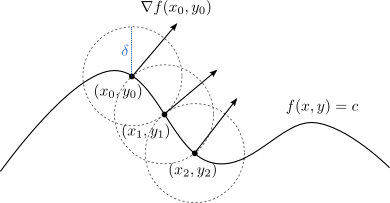

In [63]:
def level_curve(f, x0, y0, C , delta=0.1, N=100, eps=0.01):
    L = []    
    
    for i in range(N):
        
        def F(x,y):
            return np.array([f(x,y)-C,(x-x0)**2+(y-y0)**2-delta**2])
        J_F = J(F)
        grad_f = grad(f)
        a = x0 + grad_f(x0, y0)[1]/norme(grad_f(x0, y0))*0.01    #on choisit le prochain point initial pour qu'il soit"à droite"
        b = y0 - grad_f(x0, y0)[0]/norme(grad_f(x0, y0))*0.01
        x = a + (-F(a,b)[0]*J_F(a,b)[1][1]+F(a,b)[1]*J_F(a,b)[0][1])/(J_F(a,b)[0][0]*J_F(a,b)[1][1]-J_F(a,b)[1][0]*J_F(a,b)[0][1])
        y = b + (-F(a,b)[0]*J_F(a,b)[1][0]+F(a,b)[1]*J_F(a,b)[0][0])/(J_F(a,b)[0][1]*J_F(a,b)[1][0]-J_F(a,b)[1][1]*J_F(a,b)[0][0])
        
        for i in range(100):
            if np.sqrt((x - a)**2 + (y - b)**2) <= eps :      
                break  
            else:
                a, b = x, y
                x = a + (-F(a,b)[0]*J_F(a,b)[1][1]+F(a,b)[1]*J_F(a,b)[0][1])/(J_F(a,b)[0][0]*J_F(a,b)[1][1]-J_F(a,b)[1][0]*J_F(a,b)[0][1])
                y = b + (-F(a,b)[0]*J_F(a,b)[1][0]+F(a,b)[1]*J_F(a,b)[0][0])/(J_F(a,b)[0][1]*J_F(a,b)[1][0]-J_F(a,b)[1][1]*J_F(a,b)[0][0])   
        
        x0, y0 =x, y 
        L.append([x, y])
        
    return np.array(L)  

In [64]:
M = level_curve(f2, 0.0, 1.0, 2.0 , delta=0.1, N=100, eps=0.01)    #on cherche N points de la ligne de niveau 2.0 de f2                                           
X1 = M[:,0]                                                        #en utilisant le point initial (0.0, 1.0)
Y1 = M[:,1]

In [65]:
def display_contour_3(f, X1, Y1, x0, y0, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    plt.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.scatter(X1, Y1, color="blue")    #points générés par la méthode de Newton en bleu
    plt.scatter(x0, y0, color="red")    #point initial en rouge
    plt.show()

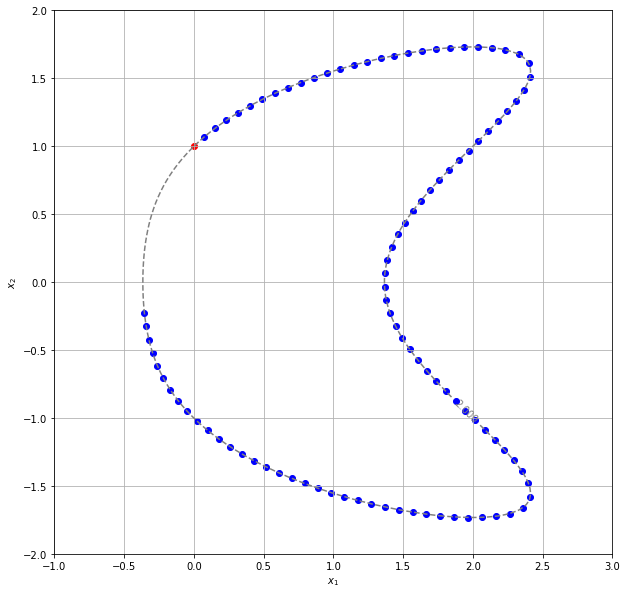

In [66]:
display_contour_3(
    f2,  
    X1,
    Y1,
    x0=0.0,
    y0=1.0,
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2.0],
)    


### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

In [67]:
def level_curve_2(f, x0, y0, C , delta=0.1, N=100, eps=0.01):
    L = []    
    X0 = [x0, y0]
    
    for i in range(N):
        
        def F(x,y):
            return np.array([f(x,y)-C,(x-x0)**2+(y-y0)**2-delta**2])
        J_F = J(F)
        grad_f = grad(f)
        a = x0 + grad_f(x0, y0)[1]/norme(grad_f(x0, y0))*0.01     #on choisit le prochain point initial pour qu'il soit"à droite"
        b = y0 - grad_f(x0, y0)[0]/norme(grad_f(x0, y0))*0.01
        x = a + (-F(a,b)[0]*J_F(a,b)[1][1]+F(a,b)[1]*J_F(a,b)[0][1])/(J_F(a,b)[0][0]*J_F(a,b)[1][1]-J_F(a,b)[1][0]*J_F(a,b)[0][1])
        y = b + (-F(a,b)[0]*J_F(a,b)[1][0]+F(a,b)[1]*J_F(a,b)[0][0])/(J_F(a,b)[0][1]*J_F(a,b)[1][0]-J_F(a,b)[1][1]*J_F(a,b)[0][0])
        
        for i in range(100):
            if np.sqrt((x - a)**2 + (y - b)**2) <= eps :      
                break 
            else:
                a, b = x, y
                x = a + (-F(a,b)[0]*J_F(a,b)[1][1]+F(a,b)[1]*J_F(a,b)[0][1])/(J_F(a,b)[0][0]*J_F(a,b)[1][1]-J_F(a,b)[1][0]*J_F(a,b)[0][1])
                y = b + (-F(a,b)[0]*J_F(a,b)[1][0]+F(a,b)[1]*J_F(a,b)[0][0])/(J_F(a,b)[0][1]*J_F(a,b)[1][0]-J_F(a,b)[1][1]*J_F(a,b)[0][0])   
        if norme([X0[0]-x, X0[1]-y]) >= delta:    #on continue si la distance entre le point courant et le point initial est plus grande que delta
            x0, y0 =x, y 
            L.append([x, y])
        else:
            break
           
    return np.array(L)  

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

In [68]:
M = level_curve_2(f2, 0.0, 1.0, 2.0 , delta=0.1, N=1000, eps=0.01)    #on cherche N points de la ligne de niveau 2.0 de f2                                           
X1 = M[:,0]                                                        #en utilisant le point initial (0.0, 1.0)
Y1 = M[:,1]

In [69]:
def display_contour_4(f, X1, Y1, x0, y0, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    plt.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.scatter(X1, Y1, color="blue")    #points générés par la méthode de Newton en bleu
    plt.scatter(x0, y0, color="red")    #point initial en rouge 
    plt.scatter(X1[-1], Y1[-1], color="yellow")    #dernier point où on s'arrête en jaune
    plt.show()

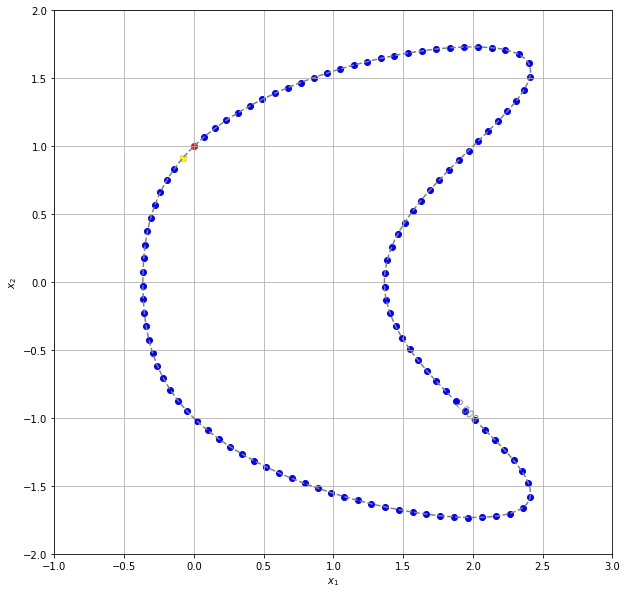

In [70]:
display_contour_4(
    f2,  
    X1,
    Y1,
    x0=0.0,
    y0=1.0,
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2.0],
)    


## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

#### Réponse 8

On a $\gamma(t)\ = (x(t),y(t))\ =  (a+bt+ct^2\ ,\ d+et+ft^2) $ donc $\gamma'(t)\ =  (b+2ct\ ,\ e+2ft)$

Notons P1 = $\binom{p_{10}}{p_{11}}$ , P2 = $\binom{p_{20}}{p_{21}}$ , u1 = $\binom{u_{10}}{u_{11}}$ , u2 = $\binom{u_{20}}{u_{21}}$

Les conditions du problème se traduisent par le système suivant:

$ \left\{\begin{matrix} a = p_{10}\\ d = p_{11}\\ a+b+c = p_{20}\\ d+e+f = p_{21}\\ b = u_{10}\\ e = u_{11}\\ b+2c = u_{20}\\e+2f = u_{21}\\ \end{matrix}\right. $

On trouve directement les expressions de a, d, b et e. Et par un petit calcul, on obtient les expressions de f et c : 

f = $\frac{u_{21}-u_{11}}{2} $ et c = $\frac{u_{20}-u_{10}}{2} $ . Mais ceci suppose qu'on ait les deux relations suivantes : 

$\left\{\begin{matrix} p_{10} + \frac{u_{20}+u_{10}}{2} = p_{20}\\ p_{11} + \frac{u_{21}+u_{11}}{2} = p_{21} \\ \end{matrix}\right.$

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [71]:
def gamma(t, P1, P2, u1, u2):
    a = P1[0]
    b = u1[0]
    c = P2[0]-P1[0]-u1[0]
    d = P1[1]
    e = u1[1]
    f = P2[1]-P1[1]-u1[1]
    if P2[0]-P1[0] == (u1[0]+u2[0])/2 and P2[1]-P1[1] == (u1[1]+u2[1])/2 :
        return (a+b*t+c*t**2, d+e*t+f*t**2)
    else:
        return (P1[0]+(P2[0]-P1[0])*t,P1[1]+(P2[1]-P1[1])*t)
     

(array([ 1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8]), array([ 0.  , -0.07, -0.08, -0.03,  0.08,  0.25,  0.48,  0.77,  1.12,  1.53]))


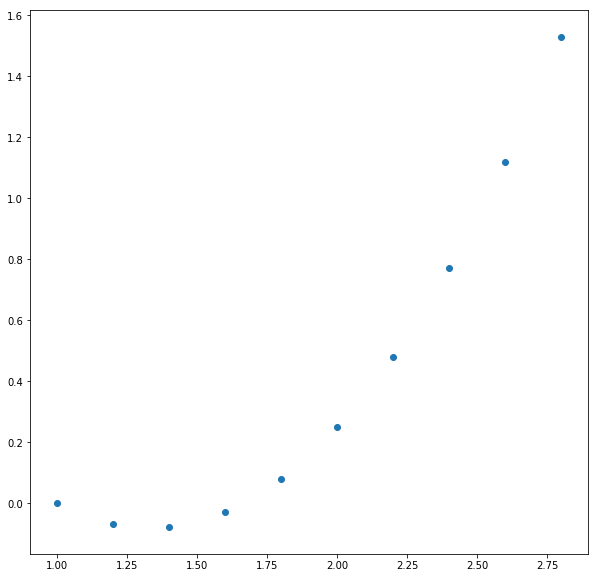

In [72]:
L = gamma(np.array([0.1*i for i in range(10)]),[1.0, 0,0], [3.0, 2.0], [2.0, -1.0], [2.0, 5.0])
print(L)
plt.scatter(L[0], L[1])
plt.show()

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [73]:
def level_curve_3(f, x0, y0, C , delta=0.1, N=100, eps=0.01, oversampling=1):
    L = []  
    X = []
    Y = []
    X0 = [x0, y0]
    for i in range(N):
        
        def F(x,y):
            return np.array([f(x,y)-C,(x-x0)**2+(y-y0)**2-delta**2])
        J_F = J(F)
        grad_f = grad(f)
        a = x0 + grad_f(x0, y0)[1]/norme(grad_f(x0, y0))*0.01    #on choisit le prochain point initial pour qu'il soit"à droite"
        b = y0 - grad_f(x0, y0)[0]/norme(grad_f(x0, y0))*0.01
        x = a + (-F(a,b)[0]*J_F(a,b)[1][1]+F(a,b)[1]*J_F(a,b)[0][1])/(J_F(a,b)[0][0]*J_F(a,b)[1][1]-J_F(a,b)[1][0]*J_F(a,b)[0][1])
        y = b + (-F(a,b)[0]*J_F(a,b)[1][0]+F(a,b)[1]*J_F(a,b)[0][0])/(J_F(a,b)[0][1]*J_F(a,b)[1][0]-J_F(a,b)[1][1]*J_F(a,b)[0][0])
        
        for i in range(100):
            if np.sqrt((x - a)**2 + (y - b)**2) <= eps :
                break             
            else:
                a, b = x, y
                x = a + (-F(a,b)[0]*J_F(a,b)[1][1]+F(a,b)[1]*J_F(a,b)[0][1])/(J_F(a,b)[0][0]*J_F(a,b)[1][1]-J_F(a,b)[1][0]*J_F(a,b)[0][1])
                y = b + (-F(a,b)[0]*J_F(a,b)[1][0]+F(a,b)[1]*J_F(a,b)[0][0])/(J_F(a,b)[0][1]*J_F(a,b)[1][0]-J_F(a,b)[1][1]*J_F(a,b)[0][0])
        
        if norme([X0[0]-x, X0[1]-y]) >= delta:   #on continue si la distance entre le point courant et le point initial est plus grande que delta
            if oversampling > 1:    #si oversampling > 1, on crée oversampling - 1 points supplémentaires par la fonction gamma 
                u = -grad_f(x0,y0)[1], grad_f(x0,y0)[0]
                v = -grad_f(x,y)[1], grad_f(x,y)[0]
                X.append(gamma(np.array(np.linspace(0, 1, oversampling + 1)), (x0, y0), (x, y), u, v)[0])
                Y.append(gamma(np.array(np.linspace(0, 1, oversampling + 1)), (x0, y0), (x, y), u, v)[1])
            x0, y0 =x, y 
            L.append([x, y])
                  
        else:
            break
              
    return np.array(L),X,Y

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

In [74]:
L,X2,Y2 = level_curve_3(f2, 0.0, 1.0, 2.0 , delta=0.5, N=5, eps=0.01, oversampling=5)    #normalement on va introduire 4 points 
                                                                                         #supplémentaires entre chaque couple de 
                                                                                         #points consécutifs

In [75]:
def display_contour_4(f, X1, Y1, X2, Y2, x0, y0, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    plt.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.scatter(X2, Y2, color="green", s=10.0)    #points supplémentaires en vert
    plt.scatter(X1, Y1, color="blue")    #points générés par la méthode de Newton en bleu
    plt.scatter(x0, y0, color="red")    #point initial en rouge 
    plt.scatter(X1[-1], Y1[-1], color="yellow")    #dernier point où on s'arrête en jaune
    plt.show()

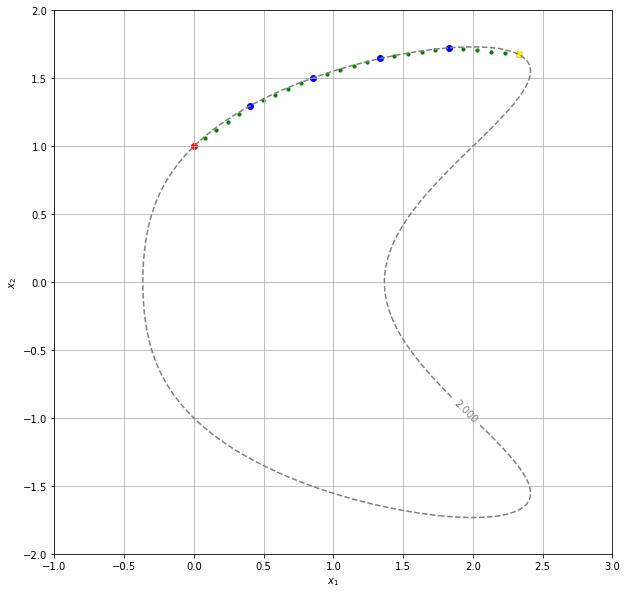

In [76]:
display_contour_4(
    f2,  
    L[:,0],
    L[:,1],
    X2,
    Y2,
    x0=0.0,
    y0=1.0,
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2.0],
)    